<a href="https://colab.research.google.com/github/scichemcode/Overdamped_LD/blob/main/Overdamped_LD_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Code to generate trajectories at different barrier heights using Overdamped Langevin Dynamics

## The potential used here is in the form

# $U(x)= E_{b}[(\frac{x}{d})^2-1]^2$

## which is a potential with two minimas.

Importing necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KernelDensity
import math

Defining functions for dedicated purposes

In [ ]:
def potential_x(x,eb,d):  # Calculate the potential
  potential=eb*((x/d)**2-1)**2
  return potential

def force_x(x, eb=6, d=1):   # Calculate force for generating the trajectory
    """Double well force: F = -dV/dx"""
    return -4 * eb * x * ((x/d)**2 - 1) / d**2

def thermal_noise(kT, gamma,m,dt):    # Include noise for randomness
    """Standard deviation of Gaussian noise"""
    return np.sqrt(2 * kT / (gamma*m)) * np.sqrt(dt)

### We will first plot the potential to have an idea on how the barrier looks like

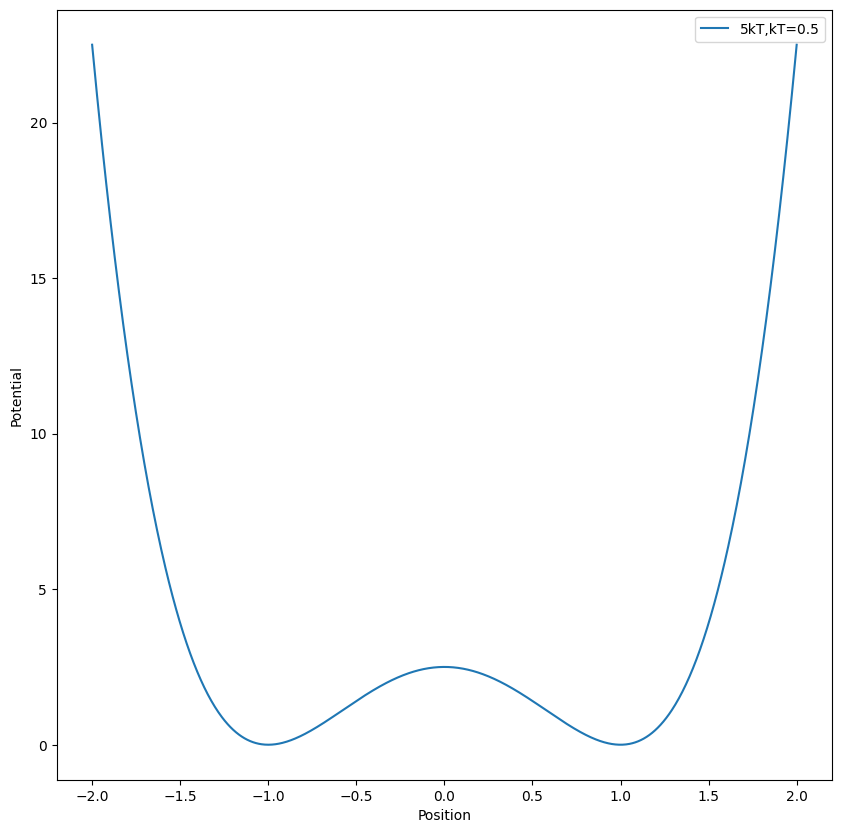

In [ ]:
kT=0.5
plt.figure(figsize=(10,10))

height=5   # we specify the height of the needed barrier here

x_analytical=np.linspace(-2,2,1000)

potential=potential_x(x_analytical,eb=height*kT,d=1)
plt.plot(x_analytical,potential,label=f"{height}kT,kT={kT}")

plt.xlabel('Position')
plt.ylabel('Potential')
plt.legend(loc='upper right')

#### The potential looks as shown above. There are two minimas at (-1,1) which is separated by a height specified.

### We as well illustrate the nature of the potential at increased barrier heights

<Figure size 1000x1000 with 0 Axes>

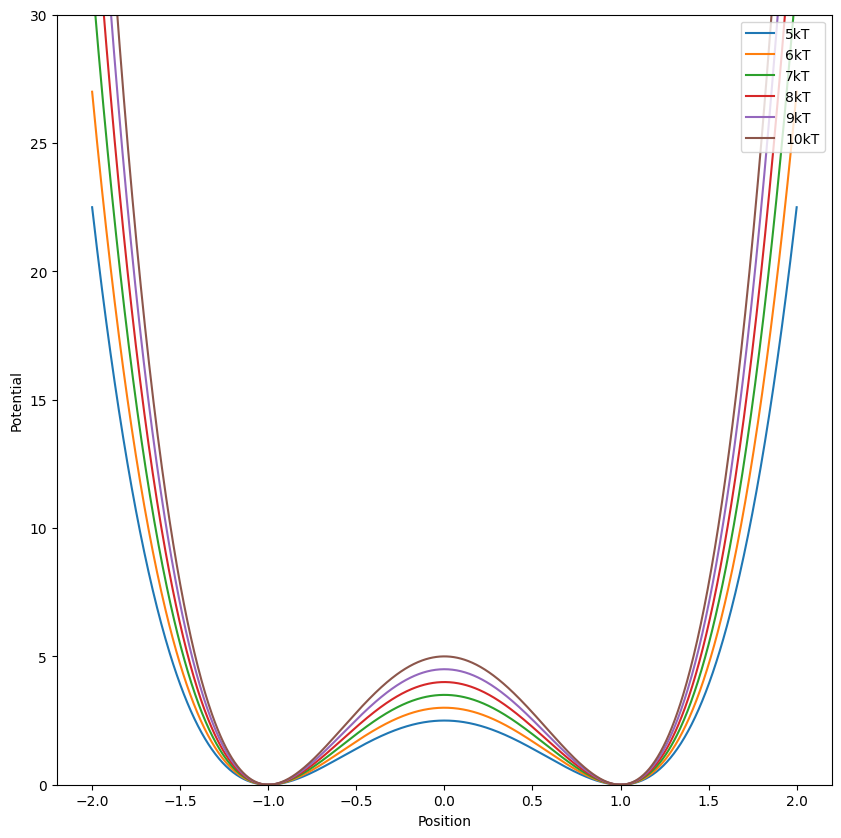

In [ ]:
kT=0.5
plt.figure(figsize=(10,10))

x_analytical=np.linspace(-2,2,1000)

eb_vals = [5,6,7,8,9,10]   # we specify a set of increasing heights

plt.figure(figsize=(10, 10))  # Create the figure once

for height in eb_vals:
    potential=potential_x(x_analytical,eb=height*kT,d=1)
    plt.plot(x_analytical,potential,label=f"{height}kT")

plt.xlabel('Position')
plt.ylabel('Potential')
plt.ylim(0,30)
plt.legend(loc='upper right')

### A further analysis to understand the potential or the trajectories and calculate the probability distribution between the two states.

<Figure size 1000x1000 with 0 Axes>

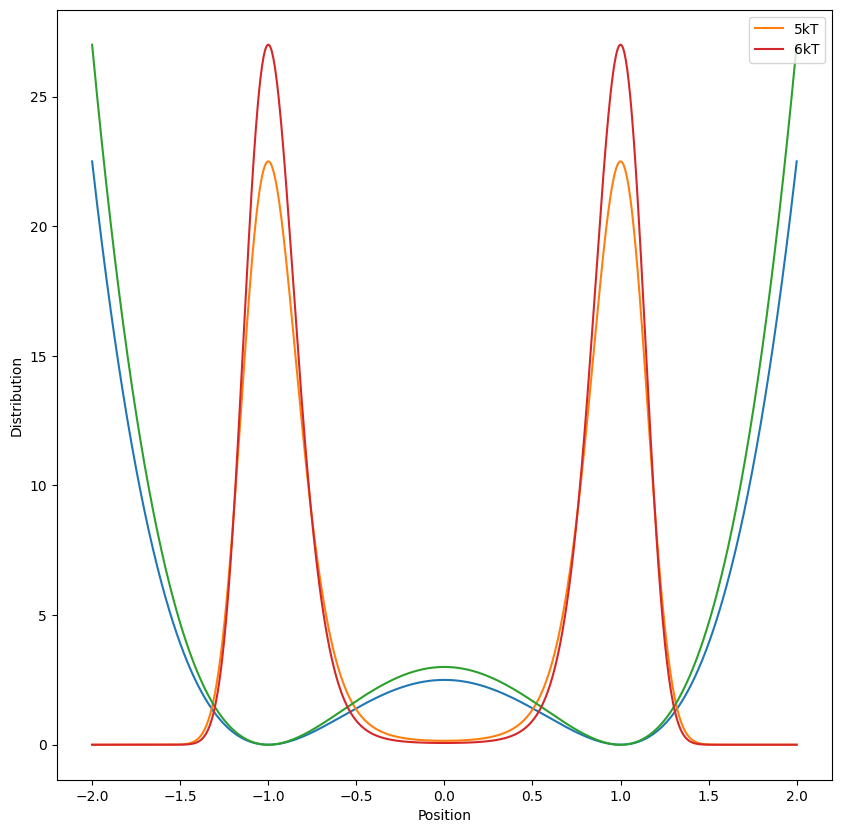

In [ ]:
plt.figure(figsize=(10,10))
kT=0.5

eb_vals = [5,6]

plt.figure(figsize=(10, 10))  # Create the figure once

for height in eb_vals:
    potential=potential_x(x_analytical,eb=height*kT,d=1)
    plt.plot(x_analytical,potential)
    distribution=np.exp(-(1/kT)*potential)
    distribution/=np.sum(distribution)
    dist_scaled = distribution * (potential.max() / distribution.max())
    plt.plot(x_analytical,dist_scaled,label=f"{height}kT")

plt.xlabel('Position')
plt.ylabel('Distribution')
plt.legend(loc='upper right')

The distribution shows that the two states are equally probable which will make sense as the potential is "symmetric".
As this is the analytical form of the potential being observed, post simulation the probability of visiting the two states must be different (rather more "rare").

## Here we simulate the particle using the Overdamped Langevin Dynamics where the position can be shown below,

## $x_{j+1}=x_{j}-\frac{\Delta t}{m\gamma}\frac{dU}{dx}|_{x_{j}}+\Delta x^{rand}$

## The position is updated based on the forces calculated under the Overdamped Langevin Dynamics.

### This part is to run the simulation for the given number of timesteps

In [ ]:
#Parameters for Overdamped LD Simulation

x0 = -1
n_steps = 100000
x = np.zeros(n_steps)
x[0] = x0
kT = 0.5
dt = 0.001
gamma = (10**9)
d = 1
m=(10**-9)*kT
saving_stride=50
time_total = n_steps*dt
noise_factor = thermal_noise(kT, gamma,m, dt)
print_index=0
np.random.seed(42)

In [ ]:
def run_simulation(x0,
                   eb_factor,
                   n_steps,
                   gamma,
                   m,
                   dt,
                   saving_stride,
                   noise_factor,
                   print_index,
                   print_steps=False,
                   kT=kT):

  eb = eb_factor*kT
  x = np.zeros(n_steps)
  x[0] = x0
  # Integration
  for i in range(1, n_steps):
    drift = (force_x(x[i-1], eb=eb, d=d) / (gamma * m))*dt
    x[i] = x[i-1] + drift + (noise_factor*np.random.choice([-1,1]))
    if print_steps:
      if i==print_index:
        print(f"{i:<8}{time_total[i]:<10.3f}{x[i]:<15.3f}{force_x(x[i]):<10.3f}")
        print_index+=saving_stride

  return x

In [ ]:
eb_vals=[2,4,5,6,10]
trajectory_each_eb={}

for height in eb_vals:
  x_simulation = run_simulation(x0=x0,
                       eb_factor=height,
                       n_steps=n_steps,
                       gamma=gamma,
                       m=m,
                       dt=dt,
                       saving_stride=saving_stride,
                       noise_factor=noise_factor,
                       print_index=print_index,
                       print_steps=False)

  trajectory_each_eb[height]=x_simulation

In [ ]:
# Saving the trajectory every given stride
traj_to_save={}
for height in eb_vals:
  traj_to_save[height]=trajectory_each_eb[height][::saving_stride]

Height= 2


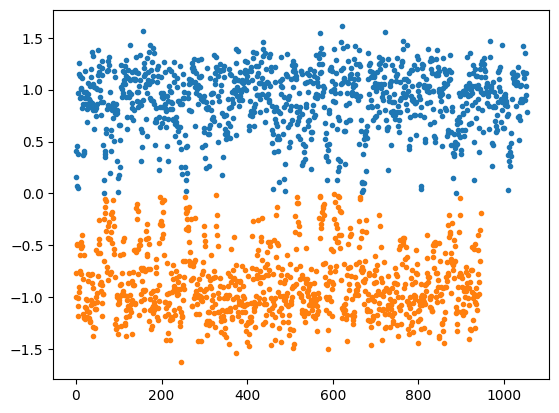

Height= 4


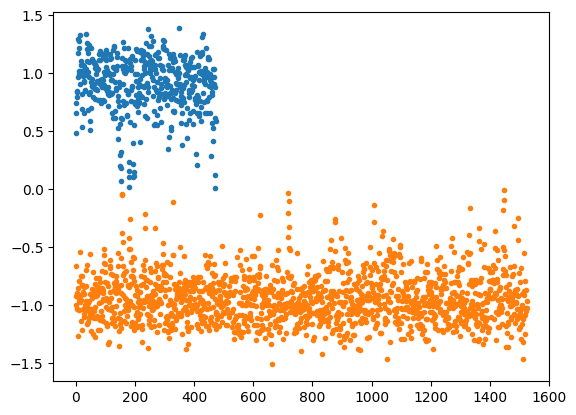

Height= 6


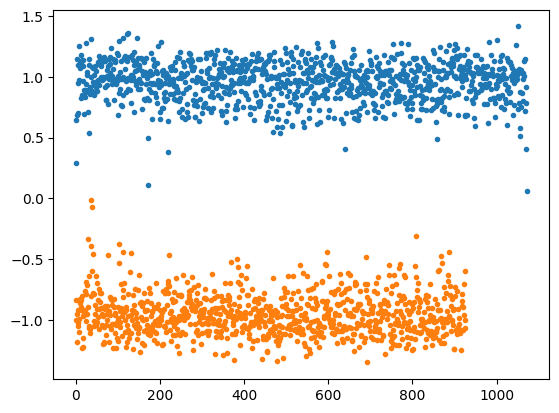

Height= 10


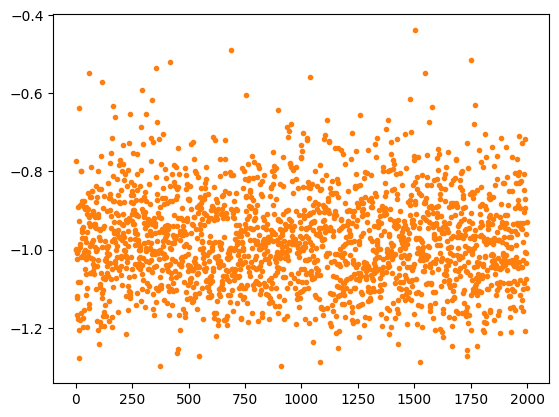

In [ ]:
interval_count=saving_stride
counts_per_height={}
eb_vals=[2,4,6,10]

for height in eb_vals:
  trajectory=trajectory_each_eb[height][::interval_count]
  points_up=trajectory[trajectory>0]
  points_down=trajectory[trajectory<0]
  print (f"Height= {height}")
  plt.plot(points_up,'.',label='Up')
  plt.plot(points_down,'.',label='Down')
  plt.show()

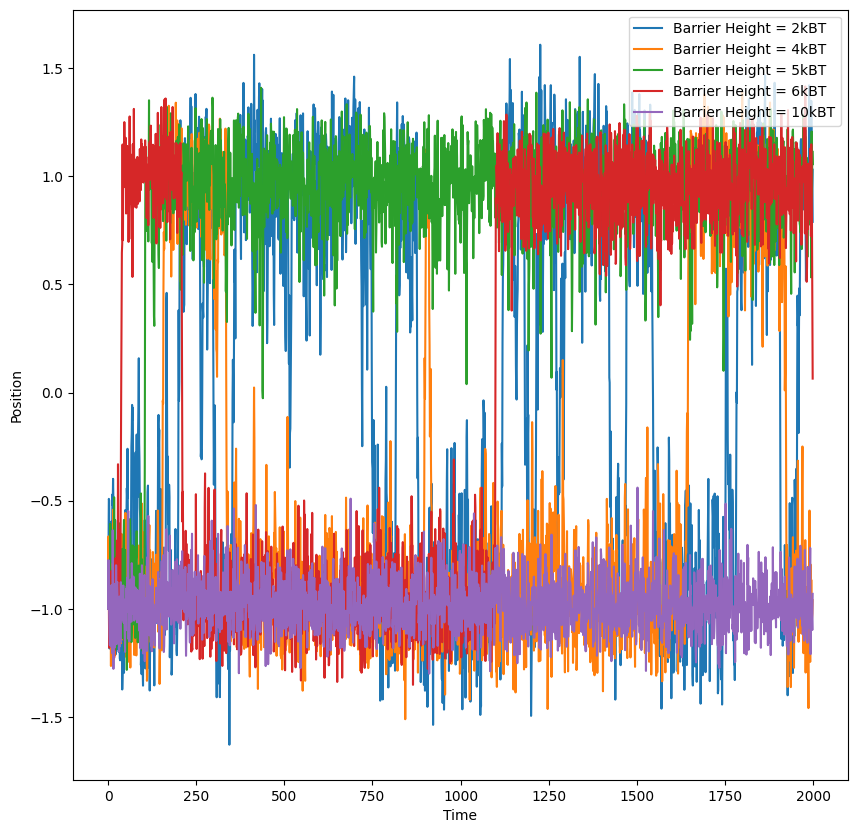

In [ ]:
plt.figure(figsize=(10, 10))

for height in eb_vals:
  plt.plot(traj_to_save[height],label=f"Barrier Height = {height}kBT")

plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(loc='upper right')

### As we observe from the time trajectories, we can see that as the barrier height increases the frequency of transitions between the two minimas decrease and at very high barrier heights, the trajectory is stuck at -1.

## Deducing the histogram of the trajectory will help understand the oscillation between the two states -1 and +1 in the simulation.

In [ ]:
eb_vals=[2,5,10]
plt.figure(figsize=(10, 10))  # Create the figure once

for height in eb_vals:
   trajectory_eb=trajectory_each_eb[height]
   sns.kdeplot(trajectory_eb, label=f"Barrier Height = {height}kBT")


plt.xlabel('Position')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.title('Position Distribution for Various Barrier Heights')